In [ ]:
import argparse

import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm

try:
    from apex import amp

except ImportError:
    amp = None

    
from skimage import io

# from dataset import LMDBDataset
from pixelsnail import PixelSNAIL
from scheduler import CycleScheduler

import argparse
import sys
import os
from skimage import io

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils
import matplotlib.patches as mpatches


# from scheduler import CycleScheduler
from pt_utils import  Embeddings, Trainer, VQVAE, data_sampler, Vqvae2Adaptive
from torch.utils import data
from torch import distributed as dist

from umap import UMAP
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from collections import Counter
from skimage import transform, metrics
import skimage
import pandas as pd
import numpy as np
import glob

from torchsummary import summary

from tqdm.notebook import trange, tqdm
import torchvision
from PIL import Image

import numpy as np
from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter
import scipy as sp
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import joblib
import pickle

from tensordict import TensorDict

seed = 51
np.random.seed(seed)
torch.manual_seed(seed)

# Create embeddings dataset

In [ ]:
# dataset_path = '../data/dataset_512/'
# dataset_path = '../datasets/bc_right_sub_left_minmax_4x_360'
# dataset_path = '../datasets/bc_left_4x_360'
# dataset_path = '../datasets/original/o_bc_left_9x_512_360'
# dataset_path = '../datasets/original/o_bc_left_4x_768_360'

dataset_path = '../datasets/imagenet_256_5'

new_dataset_path='../datasets/imagenet_256_5_embs'

if os.path.exists(new_dataset_path) is False:
    os.mkdir(new_dataset_path)

device='cuda'

resize_shape = (256, 256)
# resize_shape = (1024, 1024)

batch_size = 4

transform = transforms.Compose(
    [
        transforms.Resize(resize_shape),
        # transforms.CenterCrop(resize_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
# model_file = 'data/logs/emb_dim_1_n_embed_512_bc_left_9x_512_360/vqvae_010_train_0.01894_test_0.01887.pt'
# model_file = 'data/logs/emb_dim_1_n_embed_256_bc_left_9x_512_360/vqvae_007_train_0.01952_test_0.01941.pt'
# model_file = 'data/logs/emb_dim_1_n_embed_256_bc_left_4x_768_360/vqvae_003_train_0.02021_test_0.01998.pt'

model_path='/logs/imagenet256_5_orig/vqvae_032_train_0.01693_test_0.01794.pt'

model =      VQVAE(in_channel=3,
                   channel=128,
                   n_res_block=2,
                   n_res_channel=64,
                   embed_dim=64,
                   n_embed=512,
                   decay=0.99).to(device)

dataset = datasets.ImageFolder(dataset_path, transform=transform)
device='cuda'

images_embs_t = []
images_embs_b = []

dataset_path = dataset.__dict__['root']
classes_folders = os.listdir(dataset_path)
classes_folders_images = [os.listdir(dataset_path + '/' + folder) for folder in classes_folders]
classes_folders_images_num = [len(os.listdir(dataset_path + '/' + folder)) for folder in classes_folders]

img_transform = dataset.__dict__['transform']

In [ ]:
for i in range(len(classes_folders)):
    print(f'Number of folders {i + 1}/{len(classes_folders)}')
    
    if os.path.exists(new_dataset_path + '/'+classes_folders[i]) is False:
        os.mkdir(new_dataset_path + '/'+classes_folders[i])
        
    for j in tqdm(range(classes_folders_images_num[i]), desc=f'Folder {classes_folders[i]}'):
        image_path = dataset_path + '/' + classes_folders[i] + '/' + classes_folders_images[i][j]

        image = Image.open(image_path)
        image = image.convert("RGB")
        image = img_transform(image)
        image = image.unsqueeze(0).to(device)
        

        model.zero_grad()

        _, _, _, id_t, id_b = model.encode(image)
    

        # torch.save(torch.stack([quant_t, quant_b]), new_dataset_path+ '/'+classes_folders[i]+'/'+classes_folders_images[i][j][:-5]+'.pt',)
        torch.save(TensorDict({"top": id_t, "bottom": id_b}, batch_size=[1]),
                   new_dataset_path+ '/'+classes_folders[i]+'/'+classes_folders_images[i][j][:-5]+'.pt')
        

# Train pixelsnail

In [ ]:
class EmbsDataset(torchvision.datasets.DatasetFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        pt_dict= torch.load(path)
        
        return pt_dict['top'], pt_dict['bottom']

def train(epoch, loader, model, optimizer, scheduler, device):
    loader = tqdm(loader)

    criterion = nn.CrossEntropyLoss()

    for i, (top, bottom) in tqdm(enumerate(loader)):
        model.zero_grad()

        top = top.to(device)
        bottom = bottom.to(device)
        
        top=torch.squeeze(top,[1])
        # print(top)
        bottom=torch.squeeze(bottom, [1])

        if hier == 'top':
            target = top
            out, _ = model(top)

        elif hier == 'bottom':
            target = bottom
            out, _ = model(bottom, condition=top)

        loss = criterion(out, target)
        loss.backward()

        if scheduler is not None:
            scheduler.step()
        optimizer.step()

        _, pred = out.max(1)
        correct = (pred == target).float()
        accuracy = correct.sum() / target.numel()

        lr = optimizer.param_groups[0]['lr']
        
        print(f'Train epoch: {epoch + 1}; loss: {loss.item():.5f}; acc: {accuracy:.5f}; lr: {lr:.5f}')

        
def evaluate( epoch, loader, model, optimizer, scheduler, device):
    loader = tqdm(loader)

    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for i, (top, bottom) in tqdm(enumerate(loader)):

            top = top.to(device)
            bottom = bottom.to(device)

            top=torch.squeeze(top,[1])
            bottom=torch.squeeze(bottom, [1])


            if hier == 'top':
                target = top
                out, _ = model(top)

            elif hier == 'bottom':
                target = bottom
                out, _ = model(bottom, condition=top)

            loss = criterion(out, target)

            _, pred = out.max(1)
            correct = (pred == target).float()
            accuracy = correct.sum() / target.numel()

            lr = optimizer.param_groups[0]['lr']

            print(f'Test epoch: {epoch + 1}; loss: {loss.item():.5f}; acc: {accuracy:.5f}; lr: {lr:.5f}')

            return round(loss.item()), accuracy


In [ ]:
# dataset_path = '../datasets/emb_dim_1_n_embed_256_bc_left_9x_512_360'
dataset_path='../datasets/imagenet_256_5_embs'


n_gpu = 1
batch_size = 8
val_split = 0.15

dataset = EmbsDataset(dataset_path, loader=torch.load, extensions=['.pt'])

# indices = torch.arange(0,10)
# dataset=torch.utils.data.Subset(dataset, indices)

train_dataset_len = int(len(dataset) * (1 - val_split))
test_dataset_len = len(dataset) - train_dataset_len

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_dataset_len, test_dataset_len],
                                                            generator=torch.Generator().manual_seed(seed))

train_sampler = data_sampler(train_dataset, shuffle=True, distributed=False)
test_sampler = data_sampler(test_dataset, shuffle=True, distributed=False)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size // n_gpu, sampler=train_sampler
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size // n_gpu, sampler=test_sampler
)


In [ ]:
batch=1024
hier='bottom'
lr=1e-4
channel=256
n_res_block=4
n_res_channel=256
n_out_res_block=20
n_cond_res_block=3
dropout=0.1
amp='O0'

sched=None
ckpt=None
path=None

device = 'cuda'


if hier == 'top':
    model = PixelSNAIL(
        # shape=[64, 64],
        shape=[32, 32],
        n_class=512,
        channel=channel,
        kernel_size=5,
        n_block=4,
        attention=True,
        n_res_block=n_res_block,
        res_channel=n_res_channel,
        dropout=dropout,
        n_out_res_block=n_out_res_block,
    )

elif hier == 'bottom':
    model = PixelSNAIL(
        # shape=[128, 128],
        shape=[64, 64],
        n_class=512,
        channel=channel,
        kernel_size=5,
        n_block=4,
        n_res_block=n_res_block,
        res_channel=n_res_channel,
        attention=False,
        dropout=dropout,
        n_cond_res_block=n_cond_res_block,
        cond_res_channel=n_res_channel,
    )


# if 'model' in ckpt:
#     model.load_state_dict(torch.load(ckpt))

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
torch.cuda.empty_cache()

import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
epoch=420
device='cuda'

scheduler = CycleScheduler(
    optimizer, lr, n_iter=len(train_loader) * epoch, momentum=None
)

folder_name='logs/pixelsnail'

if os.path.exists(folder_name) is False:
    os.mkdir(folder_name)


for i in range(epoch):
    train( i, train_loader, model, optimizer, None, device)
    loss, acc = evaluate( i, test_loader, model, optimizer, scheduler, device)
    torch.save(model.state_dict(), f'{folder_name}/{str(i + 1)}_pixelsnail_{hier}_loss_{loss}_acc_{acc}.pt')
         

In [ ]:
import argparse
import os

import torch
from torchvision.utils import save_image
from tqdm import tqdm

from pt_utils import VQVAE
from pixelsnail import PixelSNAIL


@torch.no_grad()
def sample_model(model, device, batch, size, temperature, condition=None):
    row = torch.zeros(batch, *size, dtype=torch.int64).to(device)
    cache = {}

    for i in tqdm(range(size[0])):
        for j in range(size[1]):
            out, cache = model(row[:, : i + 1, :], condition=condition, cache=cache)
            prob = torch.softmax(out[:, :, i, j] / temperature, 1)
            sample = torch.multinomial(prob, 1).squeeze(-1)
            row[:, i, j] = sample

    return row

lr=1e-4
channel=256
n_res_block=4
n_res_channel=256
n_out_res_block=20
n_cond_res_block=3
dropout=0.1
amp='O0'


def load_model(model, checkpoint, device):

    if model == 'vqvae':
        model =      VQVAE(in_channel=3,
                   channel=128,
                   n_res_block=2,
                   n_res_channel=64,
                   embed_dim=64,
                   n_embed=512,
                   decay=0.99).to(device)

    elif model == 'pixelsnail_top':
        model = PixelSNAIL(
            # shape=[64, 64],
            shape=[32, 32],
            n_class=512,
            channel=channel,
            kernel_size=5,
            n_block=4,
            attention=True,
            n_res_block=n_res_block,
            res_channel=n_res_channel,
            dropout=dropout,
            n_out_res_block=n_out_res_block,
        )

    elif model == 'pixelsnail_bottom':
        model = PixelSNAIL(
            # shape=[128, 128],
            shape=[64, 64],
            n_class=512,
            channel=channel,
            kernel_size=5,
            n_block=4,
            n_res_block=n_res_block,
            res_channel=n_res_channel,
            attention=False,
            dropout=dropout,
            n_cond_res_block=n_cond_res_block,
            cond_res_channel=n_res_channel,
        )


    model.load_state_dict(torch.load(checkpoint))
    model = model.to(device)
    model.eval()

    return model

In [ ]:
device = 'cuda'

# parser = argparse.ArgumentParser()
# parser.add_argument('--batch', type=int, default=8)
# parser.add_argument('--vqvae', type=str)
# parser.add_argument('--top', type=str)
# parser.add_argument('--bottom', type=str)
# parser.add_argument('--temp', type=float, default=1.0)
# parser.add_argument('filename', type=str)

# args = parser.parse_args()

vqvae_path='logs/imagenet256_5_orig/vqvae_032_train_0.01693_test_0.01794.pt'
pixel_snail_top='logs/pixelsnail/1_pixelsnail_top_loss_0_acc_1.0.pt'
pixel_snail_bottom='logs/pixelsnail/1_pixelsnail_bottom_loss_0_acc_1.0.pt'

model_vqvae = load_model('vqvae',vqvae_path, device)
model_top = load_model('pixelsnail_top', pixel_snail_top, device)
model_bottom = load_model('pixelsnail_bottom', pixel_snail_bottom, device)

In [ ]:
batch=1
temp=0.1


top_sample = sample_model(model_top, device, batch, [32, 32], temp)
bottom_sample = sample_model(
    model_bottom, device, batch, [64, 64], temp, condition=top_sample
)

decoded_sample = model_vqvae.decode_code(top_sample, bottom_sample)
decoded_sample = decoded_sample.clamp(-1, 1)

save_image(decoded_sample, 'test.png', normalize=True, range=(-1, 1))

In [ ]:
decoded_sample[0]

In [ ]:
img=decoded_sample[0].cpu().detach().numpy()

img=np.swapaxes(img, 0,-1)

In [ ]:
img=img+1
img*=255

img=img.astype(np.int32)

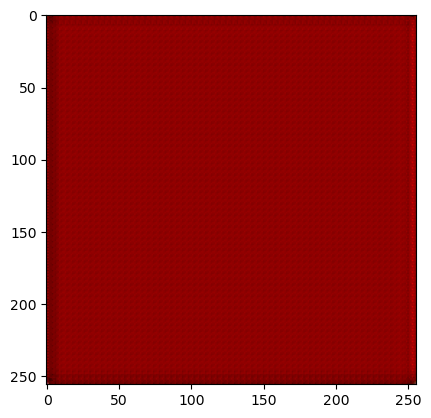

In [88]:
plt.imshow(img)